In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [2]:
df =pd.read_csv('lymphdata_clean.csv')

In [3]:
X = df.drop('class', axis=1).copy() 
X.head()

,lymphatics,block of affere,early uptake in,lym.nodes enlar,changes in node,change in stru,special forms,dislocation,no. of nodes in
0,4,2,2,2,4,8,1,1,2
1,3,2,2,3,3,4,2,2,2
2,3,2,2,4,4,8,3,2,7
3,3,1,2,3,4,4,3,1,6
4,3,1,1,2,3,5,1,2,1


In [4]:
y = df['class'].copy()
print(y)

0      3
1      2
2      3
3      3
4      2
      ..
143    3
144    2
145    3
146    2
147    2
Name: class, Length: 148, dtype: int64


Premilary tree

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.53, stratify=y, random_state=42)

clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X_train, y_train)

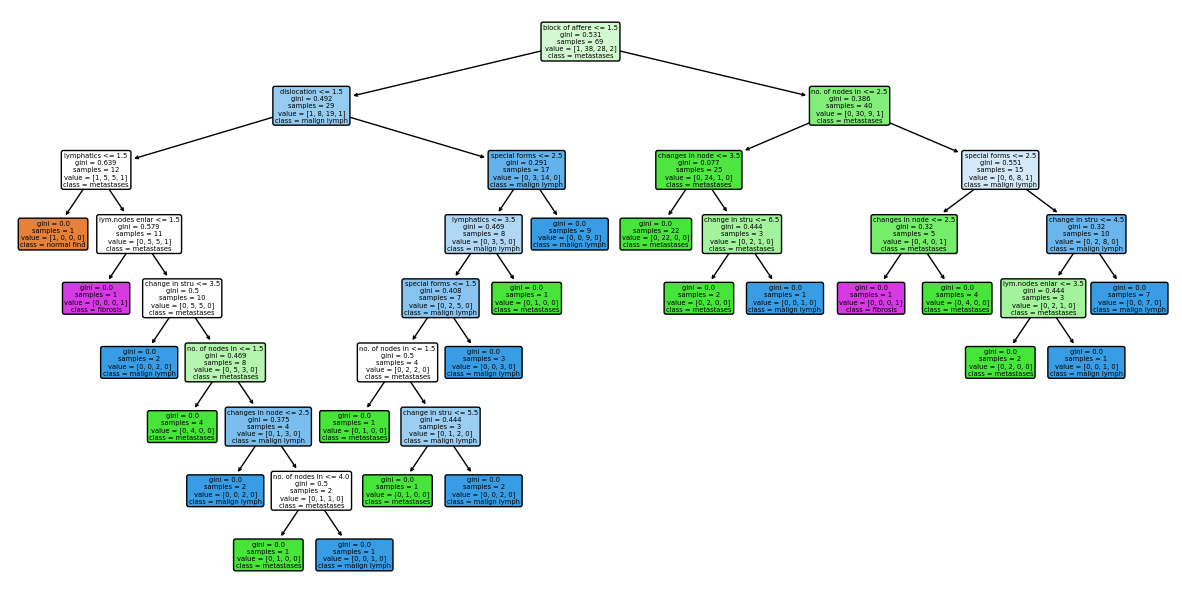

In [6]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt,
    filled=True,
    rounded=True,
    class_names=["normal find", "metastases","malign lymph","fibrosis"],
    feature_names=X.columns);

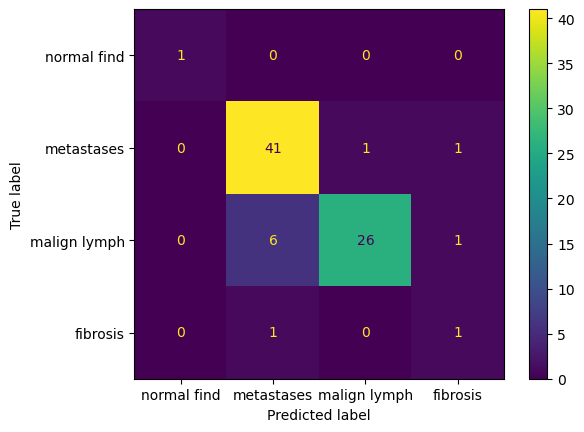

In [7]:
y_pred = clf_dt.predict(X_test)

result=confusion_matrix(y_test, y_pred, labels=clf_dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=["normal find", "metastases","malign lymph","fibrosis"])
disp.plot()

In [8]:
print("Accuracy on training set: {:. 3f}:", format(clf_dt.score(X_train, y_train)))
print("Accuracy on test set: {:. 3f}:", format(clf_dt.score(X_test, y_test)))

Accuracy on training set: {:. 3f}: 1.0
Accuracy on test set: {:. 3f}: 0.8734177215189873


Try gini tree

Accuracy on training set: {:. 3f}: 0.8260869565217391
Accuracy on test set: {:. 3f}: 0.7721518987341772


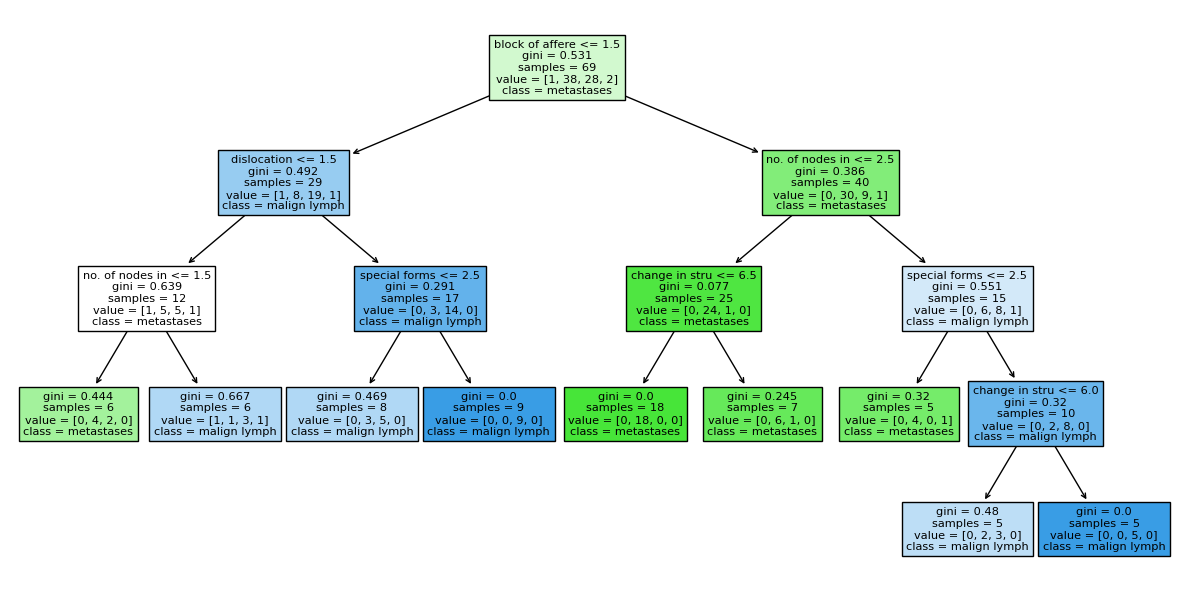

In [9]:
tree = DecisionTreeClassifier(criterion='gini',
min_samples_leaf=5,
min_samples_split=5,
max_depth=None,
random_state=42)

# Fit the tree and display the derived tree diagram with associated rules
clf_retry = tree.fit(X_train, y_train)
print("Accuracy on training set: {:. 3f}:", format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:. 3f}:", format(tree.score(X_test, y_test)))

plt.figure(figsize=(15, 7.5))
plot_tree(clf_retry,feature_names=X.columns, class_names=["normal find", "metastases","malign lymph","fibrosis"], filled=True)
plt.show()



Pruning

In [10]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas # extract different values for alpha
ccp_alphas = ccp_alphas[:-1] # exclude the max value of alpha

Clf_dts = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    Clf_dts.append(clf_dt)

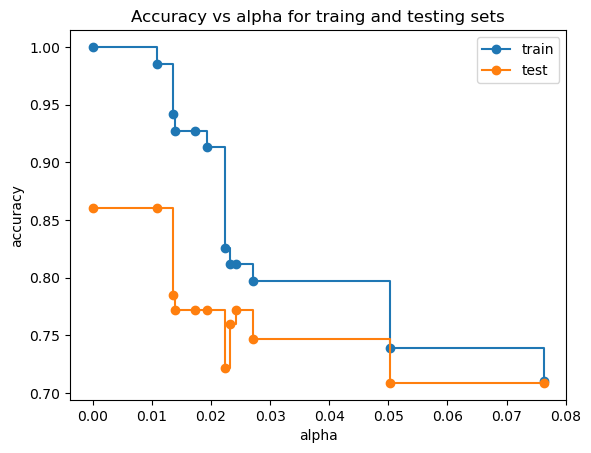

In [11]:
#Display alpha
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in Clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in Clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for traing and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\stoer\anaconda3\envs\Machine_learning\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated

<Axes: xlabel='alpha'>

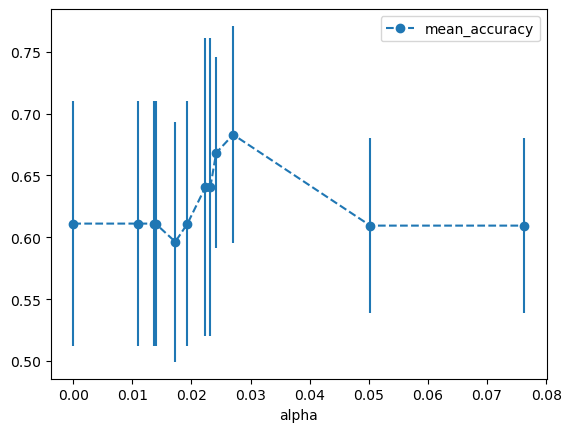

In [22]:
# An array store the results of each fold during cross validation 
alpha_loop_values = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=4)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values, 
                             columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha', 
                   y='mean_accuracy', 
                   yerr='std', 
                   marker ='o',
                   linestyle='--')

In [13]:
# Narrow down the range, find the optimal value
#alpha_results[(alpha_results['alpha'] > 0.0080)&(alpha_results['alpha'] <0.01)]

ideal_ccp_alpha = alpha_results[(alpha_results['alpha'] > 0.013)
                                &
                                (alpha_results['alpha'] <0.015)]['alpha']
ideal_ccp_alpha

In [23]:
clf_dt_pruned = DecisionTreeClassifier(random_state=42, 
                                       ccp_alpha=0.027)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

In [24]:
y_pred_pruned = clf_dt_pruned.predict(X_test)

In [25]:
print("Accuracy on pruned training set: {:. 3f}:", format(clf_dt_pruned.score(X_train, y_train)))
print("Accuracy on test set: {:. 3f}:", format(clf_dt_pruned.score(X_test, y_test)))

Accuracy on pruned training set: {:. 3f}: 0.8115942028985508
Accuracy on test set: {:. 3f}: 0.7721518987341772


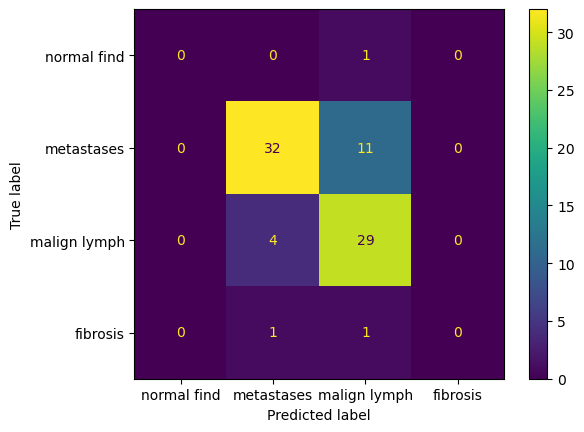

In [26]:
plot_confusion_matrix = confusion_matrix(y_test, y_pred_pruned)
disp = ConfusionMatrixDisplay(plot_confusion_matrix, display_labels=["normal find", "metastases","malign lymph","fibrosis"])
disp.plot()

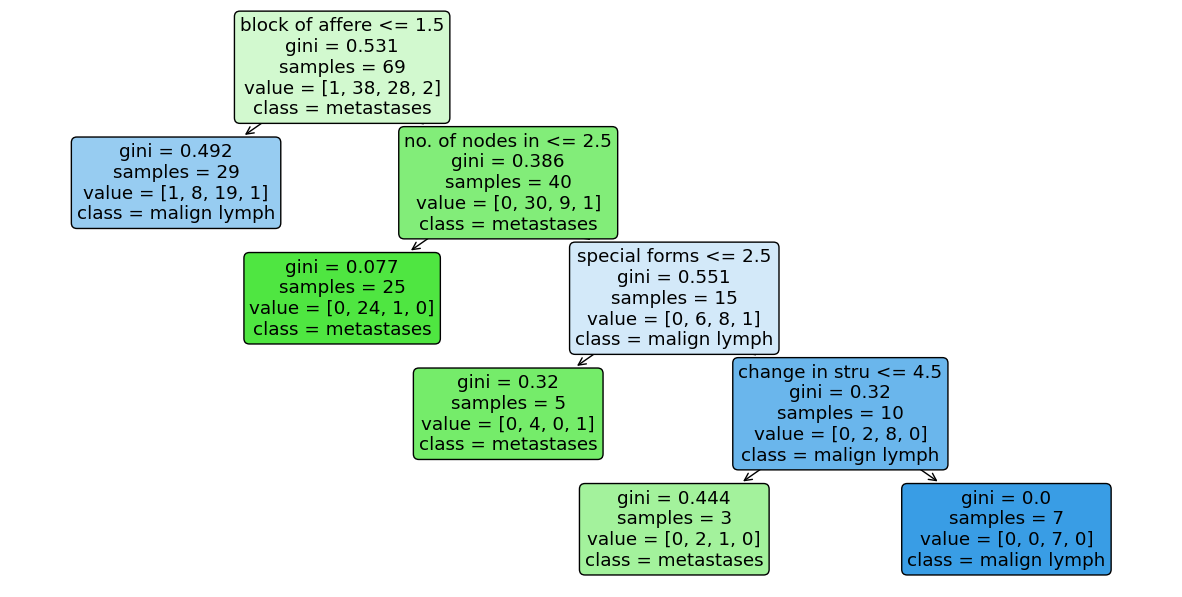

In [27]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt_pruned,
    filled=True,
    rounded=True,
    class_names=["normal find", "metastases","malign lymph","fibrosis"],
    feature_names=X.columns);